# VAE Model Testing Framework

In [1]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /notebooks


# Hyperparemeters

In [2]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed':0,
    'use_cuda_det': False,
    'enforce_det':False,
    'cublas_workspace_config': None,
}
##### Model parameters #####
model_name = 'vae_locatello'  # Name of the model architecture file (e.g., 'vae_burgess')
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder (e.g., 'bernoulli', 'gaussian')
latent_dim = 10
use_torch_compile = False  # Use torch.compile for model compilation (requires PyTorch 2.0 or higher)

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 10

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64


#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

# --- Loss Specific Hyperparameters ---
loss_name = 'group_theory'
base_loss_name = 'betavae'

group_loss_kwargs = {
    'base_loss_name': base_loss_name,
    'base_loss_kwargs': {
        'rec_dist': 'gaussian',
        'latent_dim': latent_dim,
        'beta': 16, # Default beta
        'log_kl_components': True
    },
    'rec_dist': 'gaussian',
    'device': device,
    'commutative_comparison_dist': 'gaussian',
    'commutative_weight': 3,
    'meaningful_weight': 0,
    'commutative_component_order': 2,
    'meaningful_component_order': 1,
    'meaningful_transformation_order': 1,
    'meaningful_critic_gradient_penalty_weight': 10,
    'meaningful_critic_lr': 1e-4,
    'meaningful_n_critic': 1,
    'deterministic_rep': True,
    'comp_latent_select_threshold': 0,
    'warm_up_steps': 10000,
}

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps=2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_1'

chkpt_save_master_dir=None
chkpt_viz = True

Using GPU


# Reproducibility

In [3]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 0, 'use_cuda_det': False, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [4]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

# Shapes3d

## Load dataset

In [5]:
# Load 3D Shapes
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

# num_workers_3dshapes = find_optimal_num_workers(shapes3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_3dshapes = 4

if determinism_kwargs is not None:
    shapes3d_dataloader = get_deterministic_dataloader(dataset=shapes3d_dataset, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_3dshapes,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    shapes3d_dataloader = torch.utils.data.DataLoader(shapes3d_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_3dshapes, 
                                                      shuffle=True, 
                                                      pin_memory=True)


print(f"Loaded 3D Shapes dataset with {len(shapes3d_dataset)} samples.")

Loaded 3D Shapes dataset with 480000 samples.


## Setup Model, Loss, and Optimizer

In [6]:
def setup_components(dataset, loss_kwargs):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    

    # Instantiate Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_dim=latent_dim, 
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    if loss_name == 'betatcvae':
        loss_kwargs['n_data'] = n_data
    
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"---------------------------")

    return model, loss_fn, optimizer

## Train

In [7]:
shapes3d_loss_kwargs = group_loss_kwargs.copy()

In [ ]:
print("\n===== Training on 3D Shapes =====")
model_3dshapes, loss_fn_3dshapes, optimizer_3dshapes = setup_components(shapes3d_dataset, shapes3d_loss_kwargs)

trainer_3dshapes = UnsupervisedTrainer(model=model_3dshapes,
                                      loss=loss_fn_3dshapes,
                                      optimizer=optimizer_3dshapes,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_3dshapes.train(step_unit=train_step_unit, max_steps=num_train_steps, dataloader=shapes3d_dataloader)


===== Training on 3D Shapes =====
--- Setup for Shapes3D --- 
Model: vae_locatello
Loss: group_theory (rec_dist=gaussian), kwargs={'base_loss_name': 'betavae', 'base_loss_kwargs': {'rec_dist': 'gaussian', 'latent_dim': 10, 'beta': 16, 'log_kl_components': True}, 'rec_dist': 'gaussian', 'device': device(type='cuda'), 'commutative_comparison_dist': 'gaussian', 'commutative_weight': 3, 'meaningful_weight': 0, 'commutative_component_order': 2, 'meaningful_component_order': 1, 'meaningful_transformation_order': 1, 'meaningful_critic_gradient_penalty_weight': 10, 'meaningful_critic_lr': 0.0001, 'meaningful_n_critic': 1, 'deterministic_rep': True, 'comp_latent_select_threshold': 0, 'warm_up_steps': 10000}
Optimizer: Adam
---------------------------


Training for 75000 iter, 10.00 epochs:   0%|          | 1/75000 [00:00<8:50:37,  2.36it/s]

Current step: 1, Warm-up steps: 10000, In warm-up: True
Current step: 2, Warm-up steps: 10000, In warm-up: True
Current step: 3, Warm-up steps: 10000, In warm-up: True
Current step: 4, Warm-up steps: 10000, In warm-up: True
Current step: 5, Warm-up steps: 10000, In warm-up: True
Current step: 6, Warm-up steps: 10000, In warm-up: True
Current step: 7, Warm-up steps: 10000, In warm-up: True
Current step: 8, Warm-up steps: 10000, In warm-up: True
Current step: 9, Warm-up steps: 10000, In warm-up: True
Current step: 10, Warm-up steps: 10000, In warm-up: True
Current step: 11, Warm-up steps: 10000, In warm-up: True


Training for 75000 iter, 10.00 epochs:   0%|          | 28/75000 [00:00<20:15, 61.70it/s] 

Current step: 12, Warm-up steps: 10000, In warm-up: True
Current step: 13, Warm-up steps: 10000, In warm-up: True
Current step: 14, Warm-up steps: 10000, In warm-up: True
Current step: 15, Warm-up steps: 10000, In warm-up: True
Current step: 16, Warm-up steps: 10000, In warm-up: True
Current step: 17, Warm-up steps: 10000, In warm-up: True
Current step: 18, Warm-up steps: 10000, In warm-up: True
Current step: 19, Warm-up steps: 10000, In warm-up: True
Current step: 20, Warm-up steps: 10000, In warm-up: True
Current step: 21, Warm-up steps: 10000, In warm-up: True
Current step: 22, Warm-up steps: 10000, In warm-up: True
Current step: 23, Warm-up steps: 10000, In warm-up: True
Current step: 24, Warm-up steps: 10000, In warm-up: True
Current step: 25, Warm-up steps: 10000, In warm-up: True
Current step: 26, Warm-up steps: 10000, In warm-up: True
Current step: 27, Warm-up steps: 10000, In warm-up: True
Current step: 28, Warm-up steps: 10000, In warm-up: True
Current step: 29, Warm-up steps

Training for 75000 iter, 10.00 epochs:   0%|          | 57/75000 [00:00<12:38, 98.77it/s, epoch=0.01/10.00, iter=50/75000, kl_loss=0.407, kl_loss_0=0.0439, kl_loss_1=0.0306, kl_loss_2=0.0554, kl_loss_3=0.0325, kl_loss_4=0.0391, kl_loss_5=0.0429, kl_loss_6=0.0309, kl_loss_7=0.0458, kl_loss_8=0.0445, kl_loss_9=0.0416, loss=1.92e+3, rec_loss=1.91e+3]

Current step: 39, Warm-up steps: 10000, In warm-up: True
Current step: 40, Warm-up steps: 10000, In warm-up: True
Current step: 41, Warm-up steps: 10000, In warm-up: True
Current step: 42, Warm-up steps: 10000, In warm-up: True
Current step: 43, Warm-up steps: 10000, In warm-up: True
Current step: 44, Warm-up steps: 10000, In warm-up: True
Current step: 45, Warm-up steps: 10000, In warm-up: True
Current step: 46, Warm-up steps: 10000, In warm-up: True
Current step: 47, Warm-up steps: 10000, In warm-up: True
Current step: 48, Warm-up steps: 10000, In warm-up: True
Current step: 49, Warm-up steps: 10000, In warm-up: True
Current step: 50, Warm-up steps: 10000, In warm-up: True
Current step: 51, Warm-up steps: 10000, In warm-up: True
Current step: 52, Warm-up steps: 10000, In warm-up: True
Current step: 53, Warm-up steps: 10000, In warm-up: True
Current step: 54, Warm-up steps: 10000, In warm-up: True
Current step: 55, Warm-up steps: 10000, In warm-up: True
Current step: 56, Warm-up steps

Training for 75000 iter, 10.00 epochs:   0%|          | 89/75000 [00:01<09:52, 126.34it/s, epoch=0.01/10.00, iter=50/75000, kl_loss=0.407, kl_loss_0=0.0439, kl_loss_1=0.0306, kl_loss_2=0.0554, kl_loss_3=0.0325, kl_loss_4=0.0391, kl_loss_5=0.0429, kl_loss_6=0.0309, kl_loss_7=0.0458, kl_loss_8=0.0445, kl_loss_9=0.0416, loss=1.92e+3, rec_loss=1.91e+3]

Current step: 67, Warm-up steps: 10000, In warm-up: True
Current step: 68, Warm-up steps: 10000, In warm-up: True
Current step: 69, Warm-up steps: 10000, In warm-up: True
Current step: 70, Warm-up steps: 10000, In warm-up: True
Current step: 71, Warm-up steps: 10000, In warm-up: True
Current step: 72, Warm-up steps: 10000, In warm-up: True
Current step: 73, Warm-up steps: 10000, In warm-up: True
Current step: 74, Warm-up steps: 10000, In warm-up: True
Current step: 75, Warm-up steps: 10000, In warm-up: True
Current step: 76, Warm-up steps: 10000, In warm-up: True
Current step: 77, Warm-up steps: 10000, In warm-up: True
Current step: 78, Warm-up steps: 10000, In warm-up: True
Current step: 79, Warm-up steps: 10000, In warm-up: True
Current step: 80, Warm-up steps: 10000, In warm-up: True
Current step: 81, Warm-up steps: 10000, In warm-up: True
Current step: 82, Warm-up steps: 10000, In warm-up: True
Current step: 83, Warm-up steps: 10000, In warm-up: True
Current step: 84, Warm-up steps

Training for 75000 iter, 10.00 epochs:   0%|          | 121/75000 [00:01<08:54, 140.17it/s, epoch=0.01/10.00, iter=100/75000, kl_loss=0.132, kl_loss_0=0.0171, kl_loss_1=0.0136, kl_loss_2=0.0185, kl_loss_3=0.0109, kl_loss_4=0.0103, kl_loss_5=0.00921, kl_loss_6=0.0137, kl_loss_7=0.00987, kl_loss_8=0.0134, kl_loss_9=0.0154, loss=1.72e+3, rec_loss=1.72e+3]

Current step: 99, Warm-up steps: 10000, In warm-up: True
Current step: 100, Warm-up steps: 10000, In warm-up: True
Current step: 101, Warm-up steps: 10000, In warm-up: True
Current step: 102, Warm-up steps: 10000, In warm-up: True
Current step: 103, Warm-up steps: 10000, In warm-up: True
Current step: 104, Warm-up steps: 10000, In warm-up: True
Current step: 105, Warm-up steps: 10000, In warm-up: True
Current step: 106, Warm-up steps: 10000, In warm-up: True
Current step: 107, Warm-up steps: 10000, In warm-up: True
Current step: 108, Warm-up steps: 10000, In warm-up: True
Current step: 109, Warm-up steps: 10000, In warm-up: True
Current step: 110, Warm-up steps: 10000, In warm-up: True
Current step: 111, Warm-up steps: 10000, In warm-up: True
Current step: 112, Warm-up steps: 10000, In warm-up: True
Current step: 113, Warm-up steps: 10000, In warm-up: True
Current step: 114, Warm-up steps: 10000, In warm-up: True
Current step: 115, Warm-up steps: 10000, In warm-up: True
Current step: 1

Training for 75000 iter, 10.00 epochs:   0%|          | 152/75000 [00:01<08:40, 143.78it/s, epoch=0.02/10.00, iter=150/75000, kl_loss=0.0877, kl_loss_0=0.00932, kl_loss_1=0.00714, kl_loss_2=0.00921, kl_loss_3=0.0092, kl_loss_4=0.00882, kl_loss_5=0.00907, kl_loss_6=0.00599, kl_loss_7=0.00873, kl_loss_8=0.0105, kl_loss_9=0.0097, loss=1.6e+3, rec_loss=1.6e+3]

Current step: 129, Warm-up steps: 10000, In warm-up: True
Current step: 130, Warm-up steps: 10000, In warm-up: True
Current step: 131, Warm-up steps: 10000, In warm-up: True
Current step: 132, Warm-up steps: 10000, In warm-up: True
Current step: 133, Warm-up steps: 10000, In warm-up: True
Current step: 134, Warm-up steps: 10000, In warm-up: True
Current step: 135, Warm-up steps: 10000, In warm-up: True
Current step: 136, Warm-up steps: 10000, In warm-up: True
Current step: 137, Warm-up steps: 10000, In warm-up: True
Current step: 138, Warm-up steps: 10000, In warm-up: True
Current step: 139, Warm-up steps: 10000, In warm-up: True
Current step: 140, Warm-up steps: 10000, In warm-up: True
Current step: 141, Warm-up steps: 10000, In warm-up: True
Current step: 142, Warm-up steps: 10000, In warm-up: True
Current step: 143, Warm-up steps: 10000, In warm-up: True
Current step: 144, Warm-up steps: 10000, In warm-up: True
Current step: 145, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   0%|          | 185/75000 [00:01<08:23, 148.61it/s, epoch=0.02/10.00, iter=150/75000, kl_loss=0.0877, kl_loss_0=0.00932, kl_loss_1=0.00714, kl_loss_2=0.00921, kl_loss_3=0.0092, kl_loss_4=0.00882, kl_loss_5=0.00907, kl_loss_6=0.00599, kl_loss_7=0.00873, kl_loss_8=0.0105, kl_loss_9=0.0097, loss=1.6e+3, rec_loss=1.6e+3]

Current step: 160, Warm-up steps: 10000, In warm-up: True
Current step: 161, Warm-up steps: 10000, In warm-up: True
Current step: 162, Warm-up steps: 10000, In warm-up: True
Current step: 163, Warm-up steps: 10000, In warm-up: True
Current step: 164, Warm-up steps: 10000, In warm-up: True
Current step: 165, Warm-up steps: 10000, In warm-up: True
Current step: 166, Warm-up steps: 10000, In warm-up: True
Current step: 167, Warm-up steps: 10000, In warm-up: True
Current step: 168, Warm-up steps: 10000, In warm-up: True
Current step: 169, Warm-up steps: 10000, In warm-up: True
Current step: 170, Warm-up steps: 10000, In warm-up: True
Current step: 171, Warm-up steps: 10000, In warm-up: True
Current step: 172, Warm-up steps: 10000, In warm-up: True
Current step: 173, Warm-up steps: 10000, In warm-up: True
Current step: 174, Warm-up steps: 10000, In warm-up: True
Current step: 175, Warm-up steps: 10000, In warm-up: True
Current step: 176, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   0%|          | 217/75000 [00:01<08:18, 150.13it/s, epoch=0.03/10.00, iter=200/75000, kl_loss=0.0766, kl_loss_0=0.00881, kl_loss_1=0.00649, kl_loss_2=0.00859, kl_loss_3=0.00703, kl_loss_4=0.0075, kl_loss_5=0.00809, kl_loss_6=0.00524, kl_loss_7=0.00799, kl_loss_8=0.00905, kl_loss_9=0.00781, loss=1.56e+3, rec_loss=1.56e+3]

Current step: 191, Warm-up steps: 10000, In warm-up: True
Current step: 192, Warm-up steps: 10000, In warm-up: True
Current step: 193, Warm-up steps: 10000, In warm-up: True
Current step: 194, Warm-up steps: 10000, In warm-up: True
Current step: 195, Warm-up steps: 10000, In warm-up: True
Current step: 196, Warm-up steps: 10000, In warm-up: True
Current step: 197, Warm-up steps: 10000, In warm-up: True
Current step: 198, Warm-up steps: 10000, In warm-up: True
Current step: 199, Warm-up steps: 10000, In warm-up: True
Current step: 200, Warm-up steps: 10000, In warm-up: True
Current step: 201, Warm-up steps: 10000, In warm-up: True
Current step: 202, Warm-up steps: 10000, In warm-up: True
Current step: 203, Warm-up steps: 10000, In warm-up: True
Current step: 204, Warm-up steps: 10000, In warm-up: True
Current step: 205, Warm-up steps: 10000, In warm-up: True
Current step: 206, Warm-up steps: 10000, In warm-up: True
Current step: 207, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   0%|          | 252/75000 [00:02<07:52, 158.18it/s, epoch=0.03/10.00, iter=250/75000, kl_loss=0.0619, kl_loss_0=0.00715, kl_loss_1=0.00501, kl_loss_2=0.00779, kl_loss_3=0.00599, kl_loss_4=0.00574, kl_loss_5=0.007, kl_loss_6=0.00417, kl_loss_7=0.00585, kl_loss_8=0.00761, kl_loss_9=0.00556, loss=1.54e+3, rec_loss=1.54e+3] 

Current step: 223, Warm-up steps: 10000, In warm-up: True
Current step: 224, Warm-up steps: 10000, In warm-up: True
Current step: 225, Warm-up steps: 10000, In warm-up: True
Current step: 226, Warm-up steps: 10000, In warm-up: True
Current step: 227, Warm-up steps: 10000, In warm-up: True
Current step: 228, Warm-up steps: 10000, In warm-up: True
Current step: 229, Warm-up steps: 10000, In warm-up: True
Current step: 230, Warm-up steps: 10000, In warm-up: True
Current step: 231, Warm-up steps: 10000, In warm-up: True
Current step: 232, Warm-up steps: 10000, In warm-up: True
Current step: 233, Warm-up steps: 10000, In warm-up: True
Current step: 234, Warm-up steps: 10000, In warm-up: True
Current step: 235, Warm-up steps: 10000, In warm-up: True
Current step: 236, Warm-up steps: 10000, In warm-up: True
Current step: 237, Warm-up steps: 10000, In warm-up: True
Current step: 238, Warm-up steps: 10000, In warm-up: True
Current step: 239, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   0%|          | 286/75000 [00:02<07:53, 157.86it/s, epoch=0.03/10.00, iter=250/75000, kl_loss=0.0619, kl_loss_0=0.00715, kl_loss_1=0.00501, kl_loss_2=0.00779, kl_loss_3=0.00599, kl_loss_4=0.00574, kl_loss_5=0.007, kl_loss_6=0.00417, kl_loss_7=0.00585, kl_loss_8=0.00761, kl_loss_9=0.00556, loss=1.54e+3, rec_loss=1.54e+3]

Current step: 257, Warm-up steps: 10000, In warm-up: True
Current step: 258, Warm-up steps: 10000, In warm-up: True
Current step: 259, Warm-up steps: 10000, In warm-up: True
Current step: 260, Warm-up steps: 10000, In warm-up: True
Current step: 261, Warm-up steps: 10000, In warm-up: True
Current step: 262, Warm-up steps: 10000, In warm-up: True
Current step: 263, Warm-up steps: 10000, In warm-up: True
Current step: 264, Warm-up steps: 10000, In warm-up: True
Current step: 265, Warm-up steps: 10000, In warm-up: True
Current step: 266, Warm-up steps: 10000, In warm-up: True
Current step: 267, Warm-up steps: 10000, In warm-up: True
Current step: 268, Warm-up steps: 10000, In warm-up: True
Current step: 269, Warm-up steps: 10000, In warm-up: True
Current step: 270, Warm-up steps: 10000, In warm-up: True
Current step: 271, Warm-up steps: 10000, In warm-up: True
Current step: 272, Warm-up steps: 10000, In warm-up: True
Current step: 273, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   0%|          | 304/75000 [00:02<07:40, 162.08it/s, epoch=0.04/10.00, iter=300/75000, kl_loss=0.07, kl_loss_0=0.00748, kl_loss_1=0.00529, kl_loss_2=0.00988, kl_loss_3=0.00672, kl_loss_4=0.0063, kl_loss_5=0.00721, kl_loss_6=0.00465, kl_loss_7=0.00636, kl_loss_8=0.0109, kl_loss_9=0.00527, loss=1.53e+3, rec_loss=1.53e+3]  

Current step: 290, Warm-up steps: 10000, In warm-up: True
Current step: 291, Warm-up steps: 10000, In warm-up: True
Current step: 292, Warm-up steps: 10000, In warm-up: True
Current step: 293, Warm-up steps: 10000, In warm-up: True
Current step: 294, Warm-up steps: 10000, In warm-up: True
Current step: 295, Warm-up steps: 10000, In warm-up: True
Current step: 296, Warm-up steps: 10000, In warm-up: True
Current step: 297, Warm-up steps: 10000, In warm-up: True
Current step: 298, Warm-up steps: 10000, In warm-up: True
Current step: 299, Warm-up steps: 10000, In warm-up: True
Current step: 300, Warm-up steps: 10000, In warm-up: True
Current step: 301, Warm-up steps: 10000, In warm-up: True
Current step: 302, Warm-up steps: 10000, In warm-up: True
Current step: 303, Warm-up steps: 10000, In warm-up: True
Current step: 304, Warm-up steps: 10000, In warm-up: True
Current step: 305, Warm-up steps: 10000, In warm-up: True
Current step: 306, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   0%|          | 337/75000 [00:02<08:04, 154.05it/s, epoch=0.05/10.00, iter=350/75000, kl_loss=0.0869, kl_loss_0=0.0117, kl_loss_1=0.00573, kl_loss_2=0.0126, kl_loss_3=0.00666, kl_loss_4=0.00699, kl_loss_5=0.00809, kl_loss_6=0.00675, kl_loss_7=0.00641, kl_loss_8=0.0165, kl_loss_9=0.00542, loss=1.53e+3, rec_loss=1.53e+3]

Current step: 322, Warm-up steps: 10000, In warm-up: True
Current step: 323, Warm-up steps: 10000, In warm-up: True
Current step: 324, Warm-up steps: 10000, In warm-up: True
Current step: 325, Warm-up steps: 10000, In warm-up: True
Current step: 326, Warm-up steps: 10000, In warm-up: True
Current step: 327, Warm-up steps: 10000, In warm-up: True
Current step: 328, Warm-up steps: 10000, In warm-up: True
Current step: 329, Warm-up steps: 10000, In warm-up: True
Current step: 330, Warm-up steps: 10000, In warm-up: True
Current step: 331, Warm-up steps: 10000, In warm-up: True
Current step: 332, Warm-up steps: 10000, In warm-up: True
Current step: 333, Warm-up steps: 10000, In warm-up: True
Current step: 334, Warm-up steps: 10000, In warm-up: True
Current step: 335, Warm-up steps: 10000, In warm-up: True
Current step: 336, Warm-up steps: 10000, In warm-up: True
Current step: 337, Warm-up steps: 10000, In warm-up: True
Current step: 338, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   0%|          | 369/75000 [00:02<08:16, 150.33it/s, epoch=0.05/10.00, iter=350/75000, kl_loss=0.0869, kl_loss_0=0.0117, kl_loss_1=0.00573, kl_loss_2=0.0126, kl_loss_3=0.00666, kl_loss_4=0.00699, kl_loss_5=0.00809, kl_loss_6=0.00675, kl_loss_7=0.00641, kl_loss_8=0.0165, kl_loss_9=0.00542, loss=1.53e+3, rec_loss=1.53e+3]

Current step: 352, Warm-up steps: 10000, In warm-up: True
Current step: 353, Warm-up steps: 10000, In warm-up: True
Current step: 354, Warm-up steps: 10000, In warm-up: True
Current step: 355, Warm-up steps: 10000, In warm-up: True
Current step: 356, Warm-up steps: 10000, In warm-up: True
Current step: 357, Warm-up steps: 10000, In warm-up: True
Current step: 358, Warm-up steps: 10000, In warm-up: True
Current step: 359, Warm-up steps: 10000, In warm-up: True
Current step: 360, Warm-up steps: 10000, In warm-up: True
Current step: 361, Warm-up steps: 10000, In warm-up: True
Current step: 362, Warm-up steps: 10000, In warm-up: True
Current step: 363, Warm-up steps: 10000, In warm-up: True
Current step: 364, Warm-up steps: 10000, In warm-up: True
Current step: 365, Warm-up steps: 10000, In warm-up: True
Current step: 366, Warm-up steps: 10000, In warm-up: True
Current step: 367, Warm-up steps: 10000, In warm-up: True
Current step: 368, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 400/75000 [00:03<08:20, 149.18it/s, epoch=0.05/10.00, iter=400/75000, kl_loss=0.201, kl_loss_0=0.0288, kl_loss_1=0.011, kl_loss_2=0.0359, kl_loss_3=0.00889, kl_loss_4=0.0158, kl_loss_5=0.0131, kl_loss_6=0.0114, kl_loss_7=0.0148, kl_loss_8=0.0537, kl_loss_9=0.007, loss=1.52e+3, rec_loss=1.52e+3]         

Current step: 382, Warm-up steps: 10000, In warm-up: True
Current step: 383, Warm-up steps: 10000, In warm-up: True
Current step: 384, Warm-up steps: 10000, In warm-up: True
Current step: 385, Warm-up steps: 10000, In warm-up: True
Current step: 386, Warm-up steps: 10000, In warm-up: True
Current step: 387, Warm-up steps: 10000, In warm-up: True
Current step: 388, Warm-up steps: 10000, In warm-up: True
Current step: 389, Warm-up steps: 10000, In warm-up: True
Current step: 390, Warm-up steps: 10000, In warm-up: True
Current step: 391, Warm-up steps: 10000, In warm-up: True
Current step: 392, Warm-up steps: 10000, In warm-up: True
Current step: 393, Warm-up steps: 10000, In warm-up: True
Current step: 394, Warm-up steps: 10000, In warm-up: True
Current step: 395, Warm-up steps: 10000, In warm-up: True
Current step: 396, Warm-up steps: 10000, In warm-up: True
Current step: 397, Warm-up steps: 10000, In warm-up: True
Current step: 398, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 431/75000 [00:03<08:18, 149.65it/s, epoch=0.05/10.00, iter=400/75000, kl_loss=0.201, kl_loss_0=0.0288, kl_loss_1=0.011, kl_loss_2=0.0359, kl_loss_3=0.00889, kl_loss_4=0.0158, kl_loss_5=0.0131, kl_loss_6=0.0114, kl_loss_7=0.0148, kl_loss_8=0.0537, kl_loss_9=0.007, loss=1.52e+3, rec_loss=1.52e+3]

Current step: 413, Warm-up steps: 10000, In warm-up: True
Current step: 414, Warm-up steps: 10000, In warm-up: True
Current step: 415, Warm-up steps: 10000, In warm-up: True
Current step: 416, Warm-up steps: 10000, In warm-up: True
Current step: 417, Warm-up steps: 10000, In warm-up: True
Current step: 418, Warm-up steps: 10000, In warm-up: True
Current step: 419, Warm-up steps: 10000, In warm-up: True
Current step: 420, Warm-up steps: 10000, In warm-up: True
Current step: 421, Warm-up steps: 10000, In warm-up: True
Current step: 422, Warm-up steps: 10000, In warm-up: True
Current step: 423, Warm-up steps: 10000, In warm-up: True
Current step: 424, Warm-up steps: 10000, In warm-up: True
Current step: 425, Warm-up steps: 10000, In warm-up: True
Current step: 426, Warm-up steps: 10000, In warm-up: True
Current step: 427, Warm-up steps: 10000, In warm-up: True
Current step: 428, Warm-up steps: 10000, In warm-up: True
Current step: 429, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 464/75000 [00:03<08:45, 141.88it/s, epoch=0.06/10.00, iter=450/75000, kl_loss=0.927, kl_loss_0=0.122, kl_loss_1=0.0595, kl_loss_2=0.15, kl_loss_3=0.0506, kl_loss_4=0.0749, kl_loss_5=0.055, kl_loss_6=0.0264, kl_loss_7=0.0771, kl_loss_8=0.298, kl_loss_9=0.0128, loss=1.5e+3, rec_loss=1.49e+3]     

Current step: 445, Warm-up steps: 10000, In warm-up: True
Current step: 446, Warm-up steps: 10000, In warm-up: True
Current step: 447, Warm-up steps: 10000, In warm-up: True
Current step: 448, Warm-up steps: 10000, In warm-up: True
Current step: 449, Warm-up steps: 10000, In warm-up: True
Current step: 450, Warm-up steps: 10000, In warm-up: True
Current step: 451, Warm-up steps: 10000, In warm-up: True
Current step: 452, Warm-up steps: 10000, In warm-up: True
Current step: 453, Warm-up steps: 10000, In warm-up: True
Current step: 454, Warm-up steps: 10000, In warm-up: True
Current step: 455, Warm-up steps: 10000, In warm-up: True
Current step: 456, Warm-up steps: 10000, In warm-up: True
Current step: 457, Warm-up steps: 10000, In warm-up: True
Current step: 458, Warm-up steps: 10000, In warm-up: True
Current step: 459, Warm-up steps: 10000, In warm-up: True
Current step: 460, Warm-up steps: 10000, In warm-up: True
Current step: 461, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 496/75000 [00:03<08:16, 149.98it/s, epoch=0.07/10.00, iter=500/75000, kl_loss=3.32, kl_loss_0=0.276, kl_loss_1=0.451, kl_loss_2=0.45, kl_loss_3=0.341, kl_loss_4=0.273, kl_loss_5=0.247, kl_loss_6=0.0572, kl_loss_7=0.268, kl_loss_8=0.922, kl_loss_9=0.0315, loss=1.36e+3, rec_loss=1.31e+3]    

Current step: 470, Warm-up steps: 10000, In warm-up: True
Current step: 471, Warm-up steps: 10000, In warm-up: True
Current step: 472, Warm-up steps: 10000, In warm-up: True
Current step: 473, Warm-up steps: 10000, In warm-up: True
Current step: 474, Warm-up steps: 10000, In warm-up: True
Current step: 475, Warm-up steps: 10000, In warm-up: True
Current step: 476, Warm-up steps: 10000, In warm-up: True
Current step: 477, Warm-up steps: 10000, In warm-up: True
Current step: 478, Warm-up steps: 10000, In warm-up: True
Current step: 479, Warm-up steps: 10000, In warm-up: True
Current step: 480, Warm-up steps: 10000, In warm-up: True
Current step: 481, Warm-up steps: 10000, In warm-up: True
Current step: 482, Warm-up steps: 10000, In warm-up: True
Current step: 483, Warm-up steps: 10000, In warm-up: True
Current step: 484, Warm-up steps: 10000, In warm-up: True
Current step: 485, Warm-up steps: 10000, In warm-up: True
Current step: 486, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 529/75000 [00:03<08:07, 152.76it/s, epoch=0.07/10.00, iter=500/75000, kl_loss=3.32, kl_loss_0=0.276, kl_loss_1=0.451, kl_loss_2=0.45, kl_loss_3=0.341, kl_loss_4=0.273, kl_loss_5=0.247, kl_loss_6=0.0572, kl_loss_7=0.268, kl_loss_8=0.922, kl_loss_9=0.0315, loss=1.36e+3, rec_loss=1.31e+3]

Current step: 504, Warm-up steps: 10000, In warm-up: True
Current step: 505, Warm-up steps: 10000, In warm-up: True
Current step: 506, Warm-up steps: 10000, In warm-up: True
Current step: 507, Warm-up steps: 10000, In warm-up: True
Current step: 508, Warm-up steps: 10000, In warm-up: True
Current step: 509, Warm-up steps: 10000, In warm-up: True
Current step: 510, Warm-up steps: 10000, In warm-up: True
Current step: 511, Warm-up steps: 10000, In warm-up: True
Current step: 512, Warm-up steps: 10000, In warm-up: True
Current step: 513, Warm-up steps: 10000, In warm-up: True
Current step: 514, Warm-up steps: 10000, In warm-up: True
Current step: 515, Warm-up steps: 10000, In warm-up: True
Current step: 516, Warm-up steps: 10000, In warm-up: True
Current step: 517, Warm-up steps: 10000, In warm-up: True
Current step: 518, Warm-up steps: 10000, In warm-up: True
Current step: 519, Warm-up steps: 10000, In warm-up: True
Current step: 520, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 560/75000 [00:04<08:28, 146.28it/s, epoch=0.07/10.00, iter=550/75000, kl_loss=5.03, kl_loss_0=0.361, kl_loss_1=0.889, kl_loss_2=0.541, kl_loss_3=0.448, kl_loss_4=0.351, kl_loss_5=0.497, kl_loss_6=0.101, kl_loss_7=0.399, kl_loss_8=1.37, kl_loss_9=0.0687, loss=1.16e+3, rec_loss=1.08e+3] 

Current step: 535, Warm-up steps: 10000, In warm-up: True
Current step: 536, Warm-up steps: 10000, In warm-up: True
Current step: 537, Warm-up steps: 10000, In warm-up: True
Current step: 538, Warm-up steps: 10000, In warm-up: True
Current step: 539, Warm-up steps: 10000, In warm-up: True
Current step: 540, Warm-up steps: 10000, In warm-up: True
Current step: 541, Warm-up steps: 10000, In warm-up: True
Current step: 542, Warm-up steps: 10000, In warm-up: True
Current step: 543, Warm-up steps: 10000, In warm-up: True
Current step: 544, Warm-up steps: 10000, In warm-up: True
Current step: 545, Warm-up steps: 10000, In warm-up: True
Current step: 546, Warm-up steps: 10000, In warm-up: True
Current step: 547, Warm-up steps: 10000, In warm-up: True
Current step: 548, Warm-up steps: 10000, In warm-up: True
Current step: 549, Warm-up steps: 10000, In warm-up: True
Current step: 550, Warm-up steps: 10000, In warm-up: True
Current step: 551, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 591/75000 [00:04<08:20, 148.65it/s, epoch=0.07/10.00, iter=550/75000, kl_loss=5.03, kl_loss_0=0.361, kl_loss_1=0.889, kl_loss_2=0.541, kl_loss_3=0.448, kl_loss_4=0.351, kl_loss_5=0.497, kl_loss_6=0.101, kl_loss_7=0.399, kl_loss_8=1.37, kl_loss_9=0.0687, loss=1.16e+3, rec_loss=1.08e+3]

Current step: 564, Warm-up steps: 10000, In warm-up: True
Current step: 565, Warm-up steps: 10000, In warm-up: True
Current step: 566, Warm-up steps: 10000, In warm-up: True
Current step: 567, Warm-up steps: 10000, In warm-up: True
Current step: 568, Warm-up steps: 10000, In warm-up: True
Current step: 569, Warm-up steps: 10000, In warm-up: True
Current step: 570, Warm-up steps: 10000, In warm-up: True
Current step: 571, Warm-up steps: 10000, In warm-up: True
Current step: 572, Warm-up steps: 10000, In warm-up: True
Current step: 573, Warm-up steps: 10000, In warm-up: True
Current step: 574, Warm-up steps: 10000, In warm-up: True
Current step: 575, Warm-up steps: 10000, In warm-up: True
Current step: 576, Warm-up steps: 10000, In warm-up: True
Current step: 577, Warm-up steps: 10000, In warm-up: True
Current step: 578, Warm-up steps: 10000, In warm-up: True
Current step: 579, Warm-up steps: 10000, In warm-up: True
Current step: 580, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 626/75000 [00:04<07:46, 159.29it/s, epoch=0.08/10.00, iter=600/75000, kl_loss=5.55, kl_loss_0=0.301, kl_loss_1=1.11, kl_loss_2=0.474, kl_loss_3=0.456, kl_loss_4=0.344, kl_loss_5=0.66, kl_loss_6=0.126, kl_loss_7=0.441, kl_loss_8=1.57, kl_loss_9=0.0605, loss=1.08e+3, rec_loss=995]      

Current step: 595, Warm-up steps: 10000, In warm-up: True
Current step: 596, Warm-up steps: 10000, In warm-up: True
Current step: 597, Warm-up steps: 10000, In warm-up: True
Current step: 598, Warm-up steps: 10000, In warm-up: True
Current step: 599, Warm-up steps: 10000, In warm-up: True
Current step: 600, Warm-up steps: 10000, In warm-up: True
Current step: 601, Warm-up steps: 10000, In warm-up: True
Current step: 602, Warm-up steps: 10000, In warm-up: True
Current step: 603, Warm-up steps: 10000, In warm-up: True
Current step: 604, Warm-up steps: 10000, In warm-up: True
Current step: 605, Warm-up steps: 10000, In warm-up: True
Current step: 606, Warm-up steps: 10000, In warm-up: True
Current step: 607, Warm-up steps: 10000, In warm-up: True
Current step: 608, Warm-up steps: 10000, In warm-up: True
Current step: 609, Warm-up steps: 10000, In warm-up: True
Current step: 610, Warm-up steps: 10000, In warm-up: True
Current step: 611, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 660/75000 [00:04<07:32, 164.16it/s, epoch=0.09/10.00, iter=650/75000, kl_loss=5.43, kl_loss_0=0.253, kl_loss_1=1.27, kl_loss_2=0.369, kl_loss_3=0.392, kl_loss_4=0.257, kl_loss_5=0.712, kl_loss_6=0.0929, kl_loss_7=0.398, kl_loss_8=1.65, kl_loss_9=0.0387, loss=1.05e+3, rec_loss=965]

Current step: 630, Warm-up steps: 10000, In warm-up: True
Current step: 631, Warm-up steps: 10000, In warm-up: True
Current step: 632, Warm-up steps: 10000, In warm-up: True
Current step: 633, Warm-up steps: 10000, In warm-up: True
Current step: 634, Warm-up steps: 10000, In warm-up: True
Current step: 635, Warm-up steps: 10000, In warm-up: True
Current step: 636, Warm-up steps: 10000, In warm-up: True
Current step: 637, Warm-up steps: 10000, In warm-up: True
Current step: 638, Warm-up steps: 10000, In warm-up: True
Current step: 639, Warm-up steps: 10000, In warm-up: True
Current step: 640, Warm-up steps: 10000, In warm-up: True
Current step: 641, Warm-up steps: 10000, In warm-up: True
Current step: 642, Warm-up steps: 10000, In warm-up: True
Current step: 643, Warm-up steps: 10000, In warm-up: True
Current step: 644, Warm-up steps: 10000, In warm-up: True
Current step: 645, Warm-up steps: 10000, In warm-up: True
Current step: 646, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 695/75000 [00:04<07:23, 167.70it/s, epoch=0.09/10.00, iter=650/75000, kl_loss=5.43, kl_loss_0=0.253, kl_loss_1=1.27, kl_loss_2=0.369, kl_loss_3=0.392, kl_loss_4=0.257, kl_loss_5=0.712, kl_loss_6=0.0929, kl_loss_7=0.398, kl_loss_8=1.65, kl_loss_9=0.0387, loss=1.05e+3, rec_loss=965]

Current step: 665, Warm-up steps: 10000, In warm-up: True
Current step: 666, Warm-up steps: 10000, In warm-up: True
Current step: 667, Warm-up steps: 10000, In warm-up: True
Current step: 668, Warm-up steps: 10000, In warm-up: True
Current step: 669, Warm-up steps: 10000, In warm-up: True
Current step: 670, Warm-up steps: 10000, In warm-up: True
Current step: 671, Warm-up steps: 10000, In warm-up: True
Current step: 672, Warm-up steps: 10000, In warm-up: True
Current step: 673, Warm-up steps: 10000, In warm-up: True
Current step: 674, Warm-up steps: 10000, In warm-up: True
Current step: 675, Warm-up steps: 10000, In warm-up: True
Current step: 676, Warm-up steps: 10000, In warm-up: True
Current step: 677, Warm-up steps: 10000, In warm-up: True
Current step: 678, Warm-up steps: 10000, In warm-up: True
Current step: 679, Warm-up steps: 10000, In warm-up: True
Current step: 680, Warm-up steps: 10000, In warm-up: True
Current step: 681, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 731/75000 [00:05<07:17, 169.71it/s, epoch=0.09/10.00, iter=700/75000, kl_loss=5.44, kl_loss_0=0.199, kl_loss_1=1.43, kl_loss_2=0.285, kl_loss_3=0.343, kl_loss_4=0.194, kl_loss_5=0.822, kl_loss_6=0.0782, kl_loss_7=0.382, kl_loss_8=1.66, kl_loss_9=0.0391, loss=1.03e+3, rec_loss=945]

Current step: 700, Warm-up steps: 10000, In warm-up: True
Current step: 701, Warm-up steps: 10000, In warm-up: True
Current step: 702, Warm-up steps: 10000, In warm-up: True
Current step: 703, Warm-up steps: 10000, In warm-up: True
Current step: 704, Warm-up steps: 10000, In warm-up: True
Current step: 705, Warm-up steps: 10000, In warm-up: True
Current step: 706, Warm-up steps: 10000, In warm-up: True
Current step: 707, Warm-up steps: 10000, In warm-up: True
Current step: 708, Warm-up steps: 10000, In warm-up: True
Current step: 709, Warm-up steps: 10000, In warm-up: True
Current step: 710, Warm-up steps: 10000, In warm-up: True
Current step: 711, Warm-up steps: 10000, In warm-up: True
Current step: 712, Warm-up steps: 10000, In warm-up: True
Current step: 713, Warm-up steps: 10000, In warm-up: True
Current step: 714, Warm-up steps: 10000, In warm-up: True
Current step: 715, Warm-up steps: 10000, In warm-up: True
Current step: 716, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 765/75000 [00:05<07:31, 164.53it/s, epoch=0.10/10.00, iter=750/75000, kl_loss=5.38, kl_loss_0=0.141, kl_loss_1=1.45, kl_loss_2=0.197, kl_loss_3=0.271, kl_loss_4=0.153, kl_loss_5=0.927, kl_loss_6=0.0684, kl_loss_7=0.375, kl_loss_8=1.76, kl_loss_9=0.0401, loss=1.01e+3, rec_loss=925]

Current step: 734, Warm-up steps: 10000, In warm-up: True
Current step: 735, Warm-up steps: 10000, In warm-up: True
Current step: 736, Warm-up steps: 10000, In warm-up: True
Current step: 737, Warm-up steps: 10000, In warm-up: True
Current step: 738, Warm-up steps: 10000, In warm-up: True
Current step: 739, Warm-up steps: 10000, In warm-up: True
Current step: 740, Warm-up steps: 10000, In warm-up: True
Current step: 741, Warm-up steps: 10000, In warm-up: True
Current step: 742, Warm-up steps: 10000, In warm-up: True
Current step: 743, Warm-up steps: 10000, In warm-up: True
Current step: 744, Warm-up steps: 10000, In warm-up: True
Current step: 745, Warm-up steps: 10000, In warm-up: True
Current step: 746, Warm-up steps: 10000, In warm-up: True
Current step: 747, Warm-up steps: 10000, In warm-up: True
Current step: 748, Warm-up steps: 10000, In warm-up: True
Current step: 749, Warm-up steps: 10000, In warm-up: True
Current step: 750, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 782/75000 [00:05<07:33, 163.66it/s, epoch=0.10/10.00, iter=750/75000, kl_loss=5.38, kl_loss_0=0.141, kl_loss_1=1.45, kl_loss_2=0.197, kl_loss_3=0.271, kl_loss_4=0.153, kl_loss_5=0.927, kl_loss_6=0.0684, kl_loss_7=0.375, kl_loss_8=1.76, kl_loss_9=0.0401, loss=1.01e+3, rec_loss=925]

Current step: 767, Warm-up steps: 10000, In warm-up: True
Current step: 768, Warm-up steps: 10000, In warm-up: True
Current step: 769, Warm-up steps: 10000, In warm-up: True
Current step: 770, Warm-up steps: 10000, In warm-up: True
Current step: 771, Warm-up steps: 10000, In warm-up: True
Current step: 772, Warm-up steps: 10000, In warm-up: True
Current step: 773, Warm-up steps: 10000, In warm-up: True
Current step: 774, Warm-up steps: 10000, In warm-up: True
Current step: 775, Warm-up steps: 10000, In warm-up: True
Current step: 776, Warm-up steps: 10000, In warm-up: True
Current step: 777, Warm-up steps: 10000, In warm-up: True
Current step: 778, Warm-up steps: 10000, In warm-up: True
Current step: 779, Warm-up steps: 10000, In warm-up: True
Current step: 780, Warm-up steps: 10000, In warm-up: True
Current step: 781, Warm-up steps: 10000, In warm-up: True
Current step: 782, Warm-up steps: 10000, In warm-up: True
Current step: 783, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 816/75000 [00:05<07:46, 159.05it/s, epoch=0.11/10.00, iter=800/75000, kl_loss=5.34, kl_loss_0=0.0926, kl_loss_1=1.54, kl_loss_2=0.129, kl_loss_3=0.214, kl_loss_4=0.103, kl_loss_5=1.09, kl_loss_6=0.0669, kl_loss_7=0.324, kl_loss_8=1.74, kl_loss_9=0.0379, loss=1e+3, rec_loss=917]   

Current step: 798, Warm-up steps: 10000, In warm-up: True
Current step: 799, Warm-up steps: 10000, In warm-up: True
Current step: 800, Warm-up steps: 10000, In warm-up: True
Current step: 801, Warm-up steps: 10000, In warm-up: True
Current step: 802, Warm-up steps: 10000, In warm-up: True
Current step: 803, Warm-up steps: 10000, In warm-up: True
Current step: 804, Warm-up steps: 10000, In warm-up: True
Current step: 805, Warm-up steps: 10000, In warm-up: True
Current step: 806, Warm-up steps: 10000, In warm-up: True
Current step: 807, Warm-up steps: 10000, In warm-up: True
Current step: 808, Warm-up steps: 10000, In warm-up: True
Current step: 809, Warm-up steps: 10000, In warm-up: True
Current step: 810, Warm-up steps: 10000, In warm-up: True
Current step: 811, Warm-up steps: 10000, In warm-up: True
Current step: 812, Warm-up steps: 10000, In warm-up: True
Current step: 813, Warm-up steps: 10000, In warm-up: True
Current step: 814, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 852/75000 [00:05<07:26, 166.12it/s, epoch=0.11/10.00, iter=850/75000, kl_loss=5.19, kl_loss_0=0.0599, kl_loss_1=1.57, kl_loss_2=0.0854, kl_loss_3=0.139, kl_loss_4=0.071, kl_loss_5=1.23, kl_loss_6=0.0654, kl_loss_7=0.222, kl_loss_8=1.72, kl_loss_9=0.036, loss=993, rec_loss=910] 

Current step: 832, Warm-up steps: 10000, In warm-up: True
Current step: 833, Warm-up steps: 10000, In warm-up: True
Current step: 834, Warm-up steps: 10000, In warm-up: True
Current step: 835, Warm-up steps: 10000, In warm-up: True
Current step: 836, Warm-up steps: 10000, In warm-up: True
Current step: 837, Warm-up steps: 10000, In warm-up: True
Current step: 838, Warm-up steps: 10000, In warm-up: True
Current step: 839, Warm-up steps: 10000, In warm-up: True
Current step: 840, Warm-up steps: 10000, In warm-up: True
Current step: 841, Warm-up steps: 10000, In warm-up: True
Current step: 842, Warm-up steps: 10000, In warm-up: True
Current step: 843, Warm-up steps: 10000, In warm-up: True
Current step: 844, Warm-up steps: 10000, In warm-up: True
Current step: 845, Warm-up steps: 10000, In warm-up: True
Current step: 846, Warm-up steps: 10000, In warm-up: True
Current step: 847, Warm-up steps: 10000, In warm-up: True
Current step: 848, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 887/75000 [00:06<07:31, 164.14it/s, epoch=0.11/10.00, iter=850/75000, kl_loss=5.19, kl_loss_0=0.0599, kl_loss_1=1.57, kl_loss_2=0.0854, kl_loss_3=0.139, kl_loss_4=0.071, kl_loss_5=1.23, kl_loss_6=0.0654, kl_loss_7=0.222, kl_loss_8=1.72, kl_loss_9=0.036, loss=993, rec_loss=910]

Current step: 865, Warm-up steps: 10000, In warm-up: True
Current step: 866, Warm-up steps: 10000, In warm-up: True
Current step: 867, Warm-up steps: 10000, In warm-up: True
Current step: 868, Warm-up steps: 10000, In warm-up: True
Current step: 869, Warm-up steps: 10000, In warm-up: True
Current step: 870, Warm-up steps: 10000, In warm-up: True
Current step: 871, Warm-up steps: 10000, In warm-up: True
Current step: 872, Warm-up steps: 10000, In warm-up: True
Current step: 873, Warm-up steps: 10000, In warm-up: True
Current step: 874, Warm-up steps: 10000, In warm-up: True
Current step: 875, Warm-up steps: 10000, In warm-up: True
Current step: 876, Warm-up steps: 10000, In warm-up: True
Current step: 877, Warm-up steps: 10000, In warm-up: True
Current step: 878, Warm-up steps: 10000, In warm-up: True
Current step: 879, Warm-up steps: 10000, In warm-up: True
Current step: 880, Warm-up steps: 10000, In warm-up: True
Current step: 881, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|          | 921/75000 [00:06<08:01, 153.71it/s, epoch=0.12/10.00, iter=900/75000, kl_loss=5.28, kl_loss_0=0.0397, kl_loss_1=1.61, kl_loss_2=0.0567, kl_loss_3=0.112, kl_loss_4=0.0561, kl_loss_5=1.34, kl_loss_6=0.0599, kl_loss_7=0.189, kl_loss_8=1.79, kl_loss_9=0.0382, loss=975, rec_loss=891]

Current step: 899, Warm-up steps: 10000, In warm-up: True
Current step: 900, Warm-up steps: 10000, In warm-up: True
Current step: 901, Warm-up steps: 10000, In warm-up: True
Current step: 902, Warm-up steps: 10000, In warm-up: True
Current step: 903, Warm-up steps: 10000, In warm-up: True
Current step: 904, Warm-up steps: 10000, In warm-up: True
Current step: 905, Warm-up steps: 10000, In warm-up: True
Current step: 906, Warm-up steps: 10000, In warm-up: True
Current step: 907, Warm-up steps: 10000, In warm-up: True
Current step: 908, Warm-up steps: 10000, In warm-up: True
Current step: 909, Warm-up steps: 10000, In warm-up: True
Current step: 910, Warm-up steps: 10000, In warm-up: True
Current step: 911, Warm-up steps: 10000, In warm-up: True
Current step: 912, Warm-up steps: 10000, In warm-up: True
Current step: 913, Warm-up steps: 10000, In warm-up: True
Current step: 914, Warm-up steps: 10000, In warm-up: True
Current step: 915, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|▏         | 954/75000 [00:06<08:00, 154.22it/s, epoch=0.13/10.00, iter=950/75000, kl_loss=5.23, kl_loss_0=0.0382, kl_loss_1=1.62, kl_loss_2=0.0488, kl_loss_3=0.0984, kl_loss_4=0.0401, kl_loss_5=1.38, kl_loss_6=0.0582, kl_loss_7=0.131, kl_loss_8=1.77, kl_loss_9=0.0382, loss=962, rec_loss=879]

Current step: 929, Warm-up steps: 10000, In warm-up: True
Current step: 930, Warm-up steps: 10000, In warm-up: True
Current step: 931, Warm-up steps: 10000, In warm-up: True
Current step: 932, Warm-up steps: 10000, In warm-up: True
Current step: 933, Warm-up steps: 10000, In warm-up: True
Current step: 934, Warm-up steps: 10000, In warm-up: True
Current step: 935, Warm-up steps: 10000, In warm-up: True
Current step: 936, Warm-up steps: 10000, In warm-up: True
Current step: 937, Warm-up steps: 10000, In warm-up: True
Current step: 938, Warm-up steps: 10000, In warm-up: True
Current step: 939, Warm-up steps: 10000, In warm-up: True
Current step: 940, Warm-up steps: 10000, In warm-up: True
Current step: 941, Warm-up steps: 10000, In warm-up: True
Current step: 942, Warm-up steps: 10000, In warm-up: True
Current step: 943, Warm-up steps: 10000, In warm-up: True
Current step: 944, Warm-up steps: 10000, In warm-up: True
Current step: 945, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|▏         | 989/75000 [00:06<07:31, 163.99it/s, epoch=0.13/10.00, iter=950/75000, kl_loss=5.23, kl_loss_0=0.0382, kl_loss_1=1.62, kl_loss_2=0.0488, kl_loss_3=0.0984, kl_loss_4=0.0401, kl_loss_5=1.38, kl_loss_6=0.0582, kl_loss_7=0.131, kl_loss_8=1.77, kl_loss_9=0.0382, loss=962, rec_loss=879]

Current step: 961, Warm-up steps: 10000, In warm-up: True
Current step: 962, Warm-up steps: 10000, In warm-up: True
Current step: 963, Warm-up steps: 10000, In warm-up: True
Current step: 964, Warm-up steps: 10000, In warm-up: True
Current step: 965, Warm-up steps: 10000, In warm-up: True
Current step: 966, Warm-up steps: 10000, In warm-up: True
Current step: 967, Warm-up steps: 10000, In warm-up: True
Current step: 968, Warm-up steps: 10000, In warm-up: True
Current step: 969, Warm-up steps: 10000, In warm-up: True
Current step: 970, Warm-up steps: 10000, In warm-up: True
Current step: 971, Warm-up steps: 10000, In warm-up: True
Current step: 972, Warm-up steps: 10000, In warm-up: True
Current step: 973, Warm-up steps: 10000, In warm-up: True
Current step: 974, Warm-up steps: 10000, In warm-up: True
Current step: 975, Warm-up steps: 10000, In warm-up: True
Current step: 976, Warm-up steps: 10000, In warm-up: True
Current step: 977, Warm-up steps: 10000, In warm-up: True
Current step: 

Training for 75000 iter, 10.00 epochs:   1%|▏         | 1024/75000 [00:07<07:20, 167.79it/s, epoch=0.13/10.00, iter=1000/75000, kl_loss=5.43, kl_loss_0=0.0447, kl_loss_1=1.66, kl_loss_2=0.0559, kl_loss_3=0.116, kl_loss_4=0.0465, kl_loss_5=1.49, kl_loss_6=0.0652, kl_loss_7=0.109, kl_loss_8=1.78, kl_loss_9=0.0543, loss=952, rec_loss=866]

Current step: 997, Warm-up steps: 10000, In warm-up: True
Current step: 998, Warm-up steps: 10000, In warm-up: True
Current step: 999, Warm-up steps: 10000, In warm-up: True
Current step: 1000, Warm-up steps: 10000, In warm-up: True
Current step: 1001, Warm-up steps: 10000, In warm-up: True
Current step: 1002, Warm-up steps: 10000, In warm-up: True
Current step: 1003, Warm-up steps: 10000, In warm-up: True
Current step: 1004, Warm-up steps: 10000, In warm-up: True
Current step: 1005, Warm-up steps: 10000, In warm-up: True
Current step: 1006, Warm-up steps: 10000, In warm-up: True
Current step: 1007, Warm-up steps: 10000, In warm-up: True
Current step: 1008, Warm-up steps: 10000, In warm-up: True
Current step: 1009, Warm-up steps: 10000, In warm-up: True
Current step: 1010, Warm-up steps: 10000, In warm-up: True
Current step: 1011, Warm-up steps: 10000, In warm-up: True
Current step: 1012, Warm-up steps: 10000, In warm-up: True
Current step: 1013, Warm-up steps: 10000, In warm-up: True


Training for 75000 iter, 10.00 epochs:   1%|▏         | 1062/75000 [00:07<06:59, 176.29it/s, epoch=0.14/10.00, iter=1050/75000, kl_loss=6.14, kl_loss_0=0.0998, kl_loss_1=1.76, kl_loss_2=0.118, kl_loss_3=0.226, kl_loss_4=0.0871, kl_loss_5=1.52, kl_loss_6=0.125, kl_loss_7=0.182, kl_loss_8=1.91, kl_loss_9=0.116, loss=923, rec_loss=825]   

Current step: 1033, Warm-up steps: 10000, In warm-up: True
Current step: 1034, Warm-up steps: 10000, In warm-up: True
Current step: 1035, Warm-up steps: 10000, In warm-up: True
Current step: 1036, Warm-up steps: 10000, In warm-up: True
Current step: 1037, Warm-up steps: 10000, In warm-up: True
Current step: 1038, Warm-up steps: 10000, In warm-up: True
Current step: 1039, Warm-up steps: 10000, In warm-up: True
Current step: 1040, Warm-up steps: 10000, In warm-up: True
Current step: 1041, Warm-up steps: 10000, In warm-up: True
Current step: 1042, Warm-up steps: 10000, In warm-up: True
Current step: 1043, Warm-up steps: 10000, In warm-up: True
Current step: 1044, Warm-up steps: 10000, In warm-up: True
Current step: 1045, Warm-up steps: 10000, In warm-up: True
Current step: 1046, Warm-up steps: 10000, In warm-up: True
Current step: 1047, Warm-up steps: 10000, In warm-up: True
Current step: 1048, Warm-up steps: 10000, In warm-up: True
Current step: 1049, Warm-up steps: 10000, In warm-up: Tr

Training for 75000 iter, 10.00 epochs:   1%|▏         | 1080/75000 [00:07<07:09, 172.23it/s, epoch=0.14/10.00, iter=1050/75000, kl_loss=6.14, kl_loss_0=0.0998, kl_loss_1=1.76, kl_loss_2=0.118, kl_loss_3=0.226, kl_loss_4=0.0871, kl_loss_5=1.52, kl_loss_6=0.125, kl_loss_7=0.182, kl_loss_8=1.91, kl_loss_9=0.116, loss=923, rec_loss=825]

Training for 75000 iter, 10.00 epochs:   1%|▏         | 1098/75000 [00:07<07:07, 172.67it/s, epoch=0.15/10.00, iter=1100/75000, kl_loss=7.72, kl_loss_0=0.145, kl_loss_1=1.89, kl_loss_2=0.346, kl_loss_3=0.637, kl_loss_4=0.157, kl_loss_5=1.66, kl_loss_6=0.282, kl_loss_7=0.404, kl_loss_8=2.01, kl_loss_9=0.186, loss=822, rec_loss=699]  

Current step: 1069, Warm-up steps: 10000, In warm-up: True
Current step: 1070, Warm-up steps: 10000, In warm-up: True
Current step: 1071, Warm-up steps: 10000, In warm-up: True
Current step: 1072, Warm-up steps: 10000, In warm-up: True
Current step: 1073, Warm-up steps: 10000, In warm-up: True
Current step: 1074, Warm-up steps: 10000, In warm-up: True
Current step: 1075, Warm-up steps: 10000, In warm-up: True
Current step: 1076, Warm-up steps: 10000, In warm-up: True
Current step: 1077, Warm-up steps: 10000, In warm-up: True
Current step: 1078, Warm-up steps: 10000, In warm-up: True
Current step: 1079, Warm-up steps: 10000, In warm-up: True
Current step: 1080, Warm-up steps: 10000, In warm-up: True
Current step: 1081, Warm-up steps: 10000, In warm-up: True
Current step: 1082, Warm-up steps: 10000, In warm-up: True
Current step: 1083, Warm-up steps: 10000, In warm-up: True
Current step: 1084, Warm-up steps: 10000, In warm-up: True
Current step: 1085, Warm-up steps: 10000, In warm-up: Tr

Training for 75000 iter, 10.00 epochs:   2%|▏         | 1133/75000 [00:07<07:21, 167.15it/s, epoch=0.15/10.00, iter=1100/75000, kl_loss=7.72, kl_loss_0=0.145, kl_loss_1=1.89, kl_loss_2=0.346, kl_loss_3=0.637, kl_loss_4=0.157, kl_loss_5=1.66, kl_loss_6=0.282, kl_loss_7=0.404, kl_loss_8=2.01, kl_loss_9=0.186, loss=822, rec_loss=699]

Current step: 1104, Warm-up steps: 10000, In warm-up: True
Current step: 1105, Warm-up steps: 10000, In warm-up: True
Current step: 1106, Warm-up steps: 10000, In warm-up: True
Current step: 1107, Warm-up steps: 10000, In warm-up: True
Current step: 1108, Warm-up steps: 10000, In warm-up: True
Current step: 1109, Warm-up steps: 10000, In warm-up: True
Current step: 1110, Warm-up steps: 10000, In warm-up: True
Current step: 1111, Warm-up steps: 10000, In warm-up: True
Current step: 1112, Warm-up steps: 10000, In warm-up: True
Current step: 1113, Warm-up steps: 10000, In warm-up: True
Current step: 1114, Warm-up steps: 10000, In warm-up: True
Current step: 1115, Warm-up steps: 10000, In warm-up: True
Current step: 1116, Warm-up steps: 10000, In warm-up: True
Current step: 1117, Warm-up steps: 10000, In warm-up: True
Current step: 1118, Warm-up steps: 10000, In warm-up: True
Current step: 1119, Warm-up steps: 10000, In warm-up: True
Current step: 1120, Warm-up steps: 10000, In warm-up: Tr

Training for 75000 iter, 10.00 epochs:   2%|▏         | 1168/75000 [00:07<07:11, 170.98it/s, epoch=0.15/10.00, iter=1150/75000, kl_loss=8.57, kl_loss_0=0.115, kl_loss_1=1.94, kl_loss_2=0.422, kl_loss_3=0.992, kl_loss_4=0.115, kl_loss_5=1.73, kl_loss_6=0.425, kl_loss_7=0.603, kl_loss_8=2.05, kl_loss_9=0.17, loss=714, rec_loss=576] 

Current step: 1137, Warm-up steps: 10000, In warm-up: True
Current step: 1138, Warm-up steps: 10000, In warm-up: True
Current step: 1139, Warm-up steps: 10000, In warm-up: True
Current step: 1140, Warm-up steps: 10000, In warm-up: True
Current step: 1141, Warm-up steps: 10000, In warm-up: True
Current step: 1142, Warm-up steps: 10000, In warm-up: True
Current step: 1143, Warm-up steps: 10000, In warm-up: True
Current step: 1144, Warm-up steps: 10000, In warm-up: True
Current step: 1145, Warm-up steps: 10000, In warm-up: True
Current step: 1146, Warm-up steps: 10000, In warm-up: True
Current step: 1147, Warm-up steps: 10000, In warm-up: True
Current step: 1148, Warm-up steps: 10000, In warm-up: True
Current step: 1149, Warm-up steps: 10000, In warm-up: True
Current step: 1150, Warm-up steps: 10000, In warm-up: True
Current step: 1151, Warm-up steps: 10000, In warm-up: True
Current step: 1152, Warm-up steps: 10000, In warm-up: True
Current step: 1153, Warm-up steps: 10000, In warm-up: Tr

Training for 75000 iter, 10.00 epochs:   2%|▏         | 1204/75000 [00:08<07:21, 167.14it/s, epoch=0.16/10.00, iter=1200/75000, kl_loss=8.7, kl_loss_0=0.0905, kl_loss_1=1.86, kl_loss_2=0.402, kl_loss_3=1.09, kl_loss_4=0.104, kl_loss_5=1.7, kl_loss_6=0.491, kl_loss_7=0.775, kl_loss_8=2.01, kl_loss_9=0.175, loss=644, rec_loss=505] 

Current step: 1172, Warm-up steps: 10000, In warm-up: True
Current step: 1173, Warm-up steps: 10000, In warm-up: True
Current step: 1174, Warm-up steps: 10000, In warm-up: True
Current step: 1175, Warm-up steps: 10000, In warm-up: True
Current step: 1176, Warm-up steps: 10000, In warm-up: True
Current step: 1177, Warm-up steps: 10000, In warm-up: True
Current step: 1178, Warm-up steps: 10000, In warm-up: True
Current step: 1179, Warm-up steps: 10000, In warm-up: True
Current step: 1180, Warm-up steps: 10000, In warm-up: True
Current step: 1181, Warm-up steps: 10000, In warm-up: True
Current step: 1182, Warm-up steps: 10000, In warm-up: True
Current step: 1183, Warm-up steps: 10000, In warm-up: True
Current step: 1184, Warm-up steps: 10000, In warm-up: True
Current step: 1185, Warm-up steps: 10000, In warm-up: True
Current step: 1186, Warm-up steps: 10000, In warm-up: True
Current step: 1187, Warm-up steps: 10000, In warm-up: True
Current step: 1188, Warm-up steps: 10000, In warm-up: Tr

Current step: 1206, Warm-up steps: 10000, In warm-up: True
Current step: 1207, Warm-up steps: 10000, In warm-up: True
Current step: 1208, Warm-up steps: 10000, In warm-up: True
Current step: 1209, Warm-up steps: 10000, In warm-up: True
Current step: 1210, Warm-up steps: 10000, In warm-up: True
Current step: 1211, Warm-up steps: 10000, In warm-up: True
Current step: 1212, Warm-up steps: 10000, In warm-up: True
Current step: 1213, Warm-up steps: 10000, In warm-up: True
Current step: 1214, Warm-up steps: 10000, In warm-up: True
Current step: 1215, Warm-up steps: 10000, In warm-up: True
Current step: 1216, Warm-up steps: 10000, In warm-up: True
Current step: 1217, Warm-up steps: 10000, In warm-up: True
Current step: 1218, Warm-up steps: 10000, In warm-up: True
Current step: 1219, Warm-up steps: 10000, In warm-up: True
Current step: 1220, Warm-up steps: 10000, In warm-up: True
Current step: 1221, Warm-up steps: 10000, In warm-up: True
Current step: 1222, Warm-up steps: 10000, In warm-up: Tr

KeyboardInterrupt: 

### Visualization

In [ ]:
visualizer_3dshapes = utils.visualize.Visualizer(vae_model=model_3dshapes, dataset=shapes3d_dataset)

#### Reconstructions

Plotting random reconstructions...


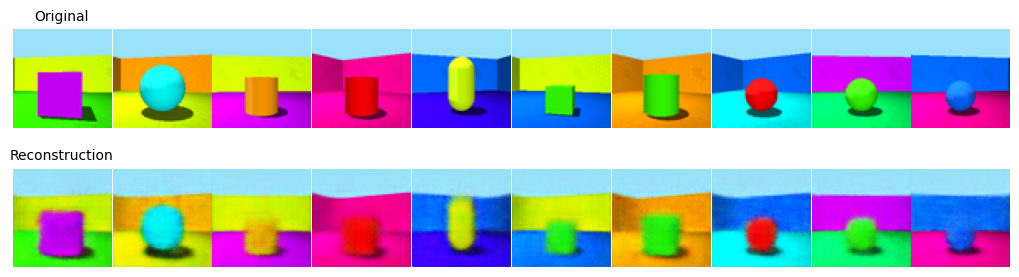

Plotting reconstructions from specific indices...


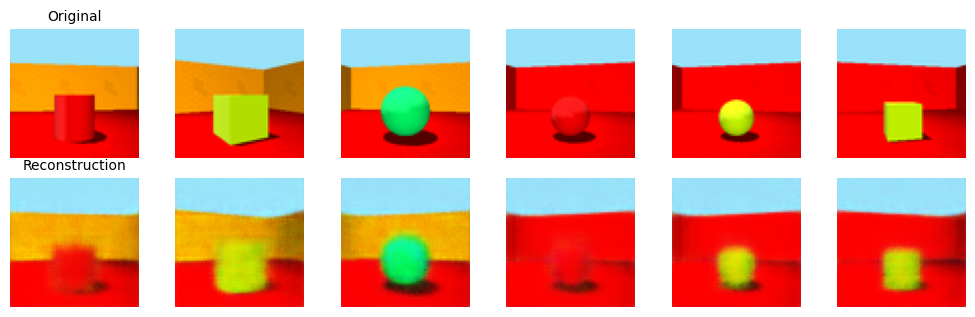

In [ ]:
print("Plotting random reconstructions...")
visualizer_3dshapes.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_3dshapes = [5000, 6000, 7000, 100, 1000, 1024] # Example indices
visualizer_3dshapes.plot_reconstructions_sub_dataset(indices_3dshapes, mode='mean')
plt.show()

#### Latent traversal

Plotting latent traversals...


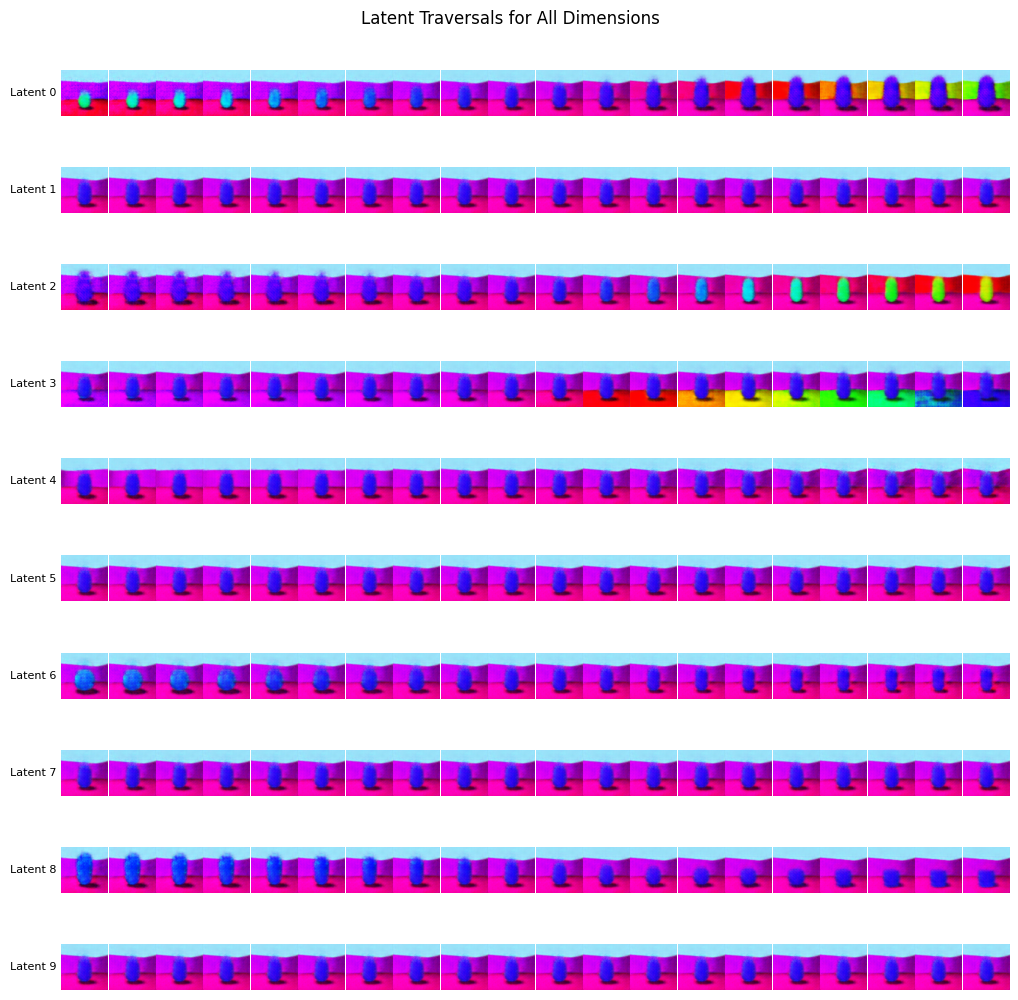

In [ ]:
print("Plotting latent traversals...")
visualizer_3dshapes.plot_all_latent_traversals(num_samples=20)
plt.show()

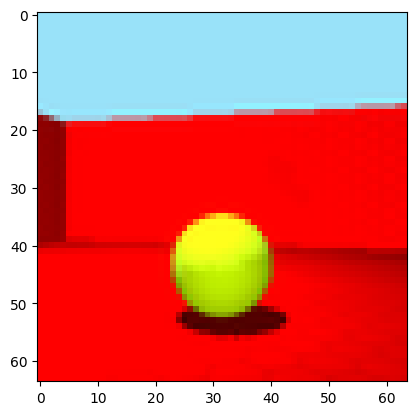

In [ ]:
ref_img_idx = 1000
ref_img = shapes3d_dataset[ref_img_idx][0]
plt.imshow(ref_img.permute(1, 2, 0).cpu().numpy())

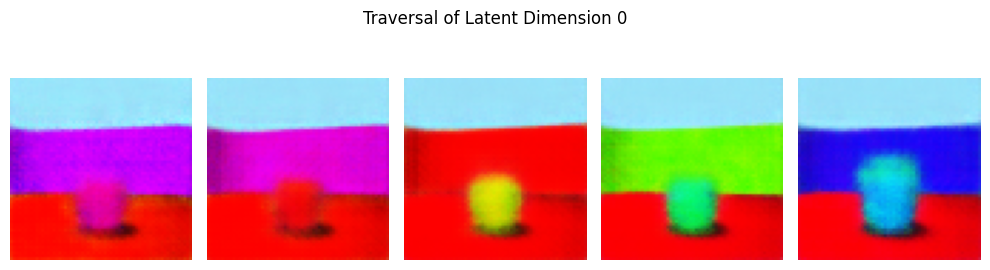

In [ ]:
# single latent traversal based on the reference image
latent_idx = 0  # Index of the latent dimension to traverse
visualizer_3dshapes.plot_single_latent_traversal(latent_idx, 
                                                 ref_img=ref_img, 
                                                 num_samples=5,
                                                 max_traversal_type='absolute', 
                                                 max_traversal=2)

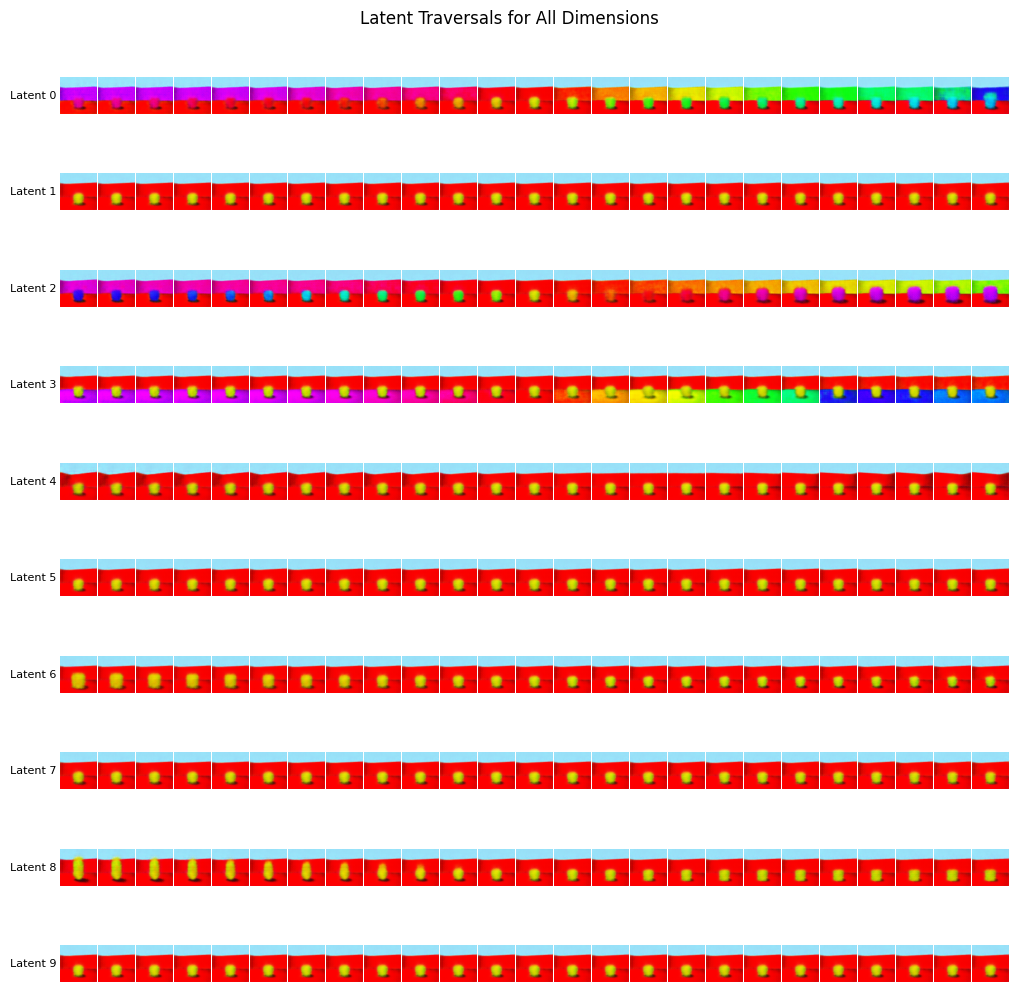

In [ ]:
visualizer_3dshapes.plot_all_latent_traversals(ref_img=ref_img, 
                                               num_samples=25,  
                                               max_traversal_type='probability',
                                               max_traversal=0.95,
                                               use_ref_img_lat_std=False
                                               )

## Metric Evaluation

In [ ]:
metrics_to_compute = [
    {'name': 'dci_d', 'args':{'num_train':10000, 'num_test':1000}}, # Added num_train and num_test
    {'name': 'mig', 'args':{}} # MIG uses default args (num_bins=20, num_workers=8, etc.)
]

metric_aggregator_3dshapes = MetricAggregator(metrics=metrics_to_compute)

print("\n===== Computing Metrics for 3D Shapes =====")
metrics_results_3dshapes = metric_aggregator_3dshapes.compute(model=model_3dshapes, 
                                                              data_loader=shapes3d_dataloader, 
                                                              device=device)
print("3D Shapes Metrics:", metrics_results_3dshapes)


===== Computing Metrics for 3D Shapes =====


Computing representations: 100%|██████████| 7500/7500 [00:21<00:00, 353.62it/s]


3D Shapes Metrics: {'dci_d': {'disentanglement': 0.5961288051096273, 'completeness': 0.6084387415094342, 'informativeness_train_scores': 0.92665, 'informativeness_test_scores': 0.8641666666666667, 'informativeness_train_errors': 0.07335000000000001, 'informativeness_test_errors': 0.13583333333333333}, 'mig': 0.42340991505749154}


# dSprites

In [16]:
# Load dSprites
Dsprites = get_dataset('dsprites')

dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 737280 samples.


## Train

In [17]:
# Beta VAE
loss_kwargs_beta_vae_dsprites =  {
    'beta': 16,
    'rec_dist': 'bernoulli', # Use the globally defined rec_dist
    'log_kl_components':True
               }

In [ ]:
print("\n===== Training on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, loss_kwargs_beta_vae_dsprites)

trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_log_loss=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      )
trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training on dSprites =====
--- Setup for DSprites --- 
Model: vae_locatello
Loss: betavae (rec_dist=bernoulli), kwargs={'beta': 16, 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
---------------------------


Training for 11520 iter, 1.00 epochs:  98%|█████████▊| 11248/11520 [01:26<00:02, 131.40it/s, epoch=0.98/1.00, iter=11250/11520, kl_loss=6.53, kl_loss_0=1.41, kl_loss_1=0.00598, kl_loss_2=1.15, kl_loss_3=0.00731, kl_loss_4=1.61, kl_loss_5=0.487, kl_loss_6=0.00637, kl_loss_7=0.653, kl_loss_8=1.17, kl_loss_9=0.0236, loss=244, rec_loss=139]          

KeyboardInterrupt: 

In [ ]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.Visualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


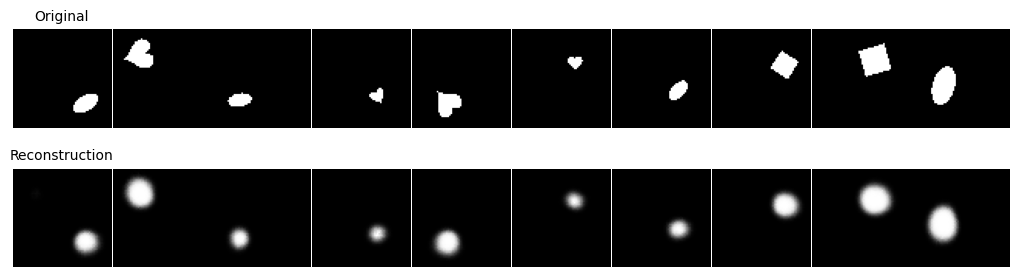

Plotting reconstructions from specific indices...


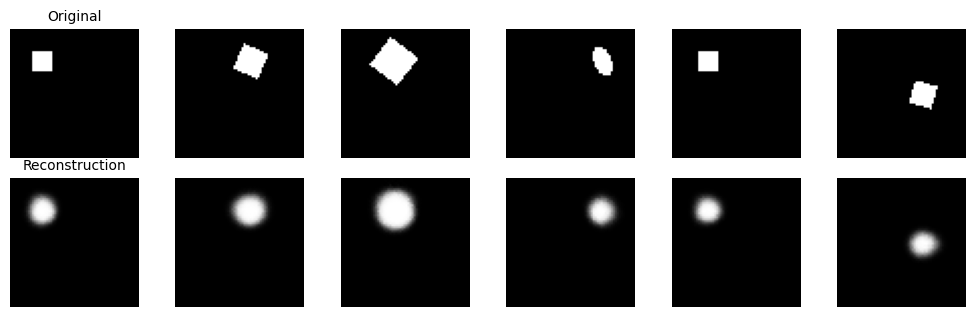

In [ ]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 100000, 200000, 300000, 40000, 50000] # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


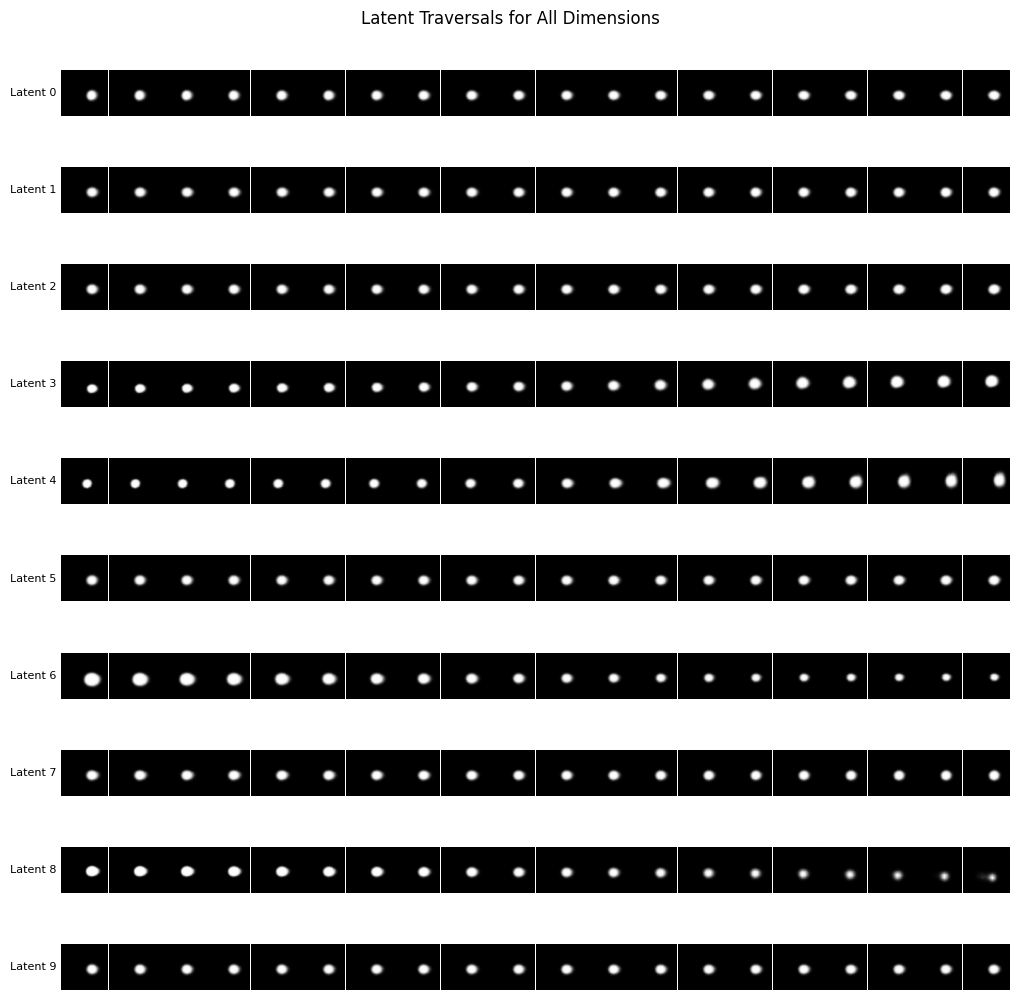

In [ ]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=20)
plt.show()

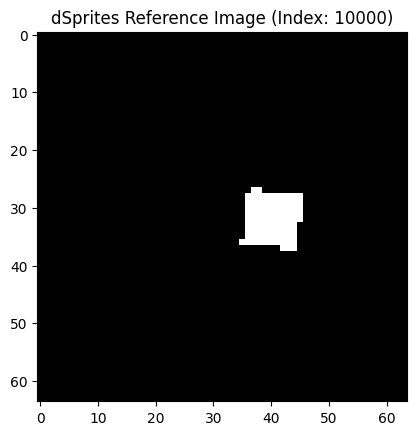

In [ ]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 10000  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()


Plotting single latent traversal for dimension 0...


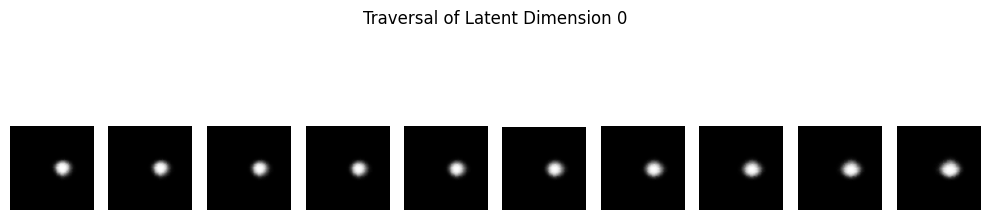

In [ ]:
# Single latent traversal based on the reference image
latent_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_idx_dsprites, ref_img=ref_img_dsprites, num_samples=10)
plt.show()

Plotting all latent traversals based on reference image...


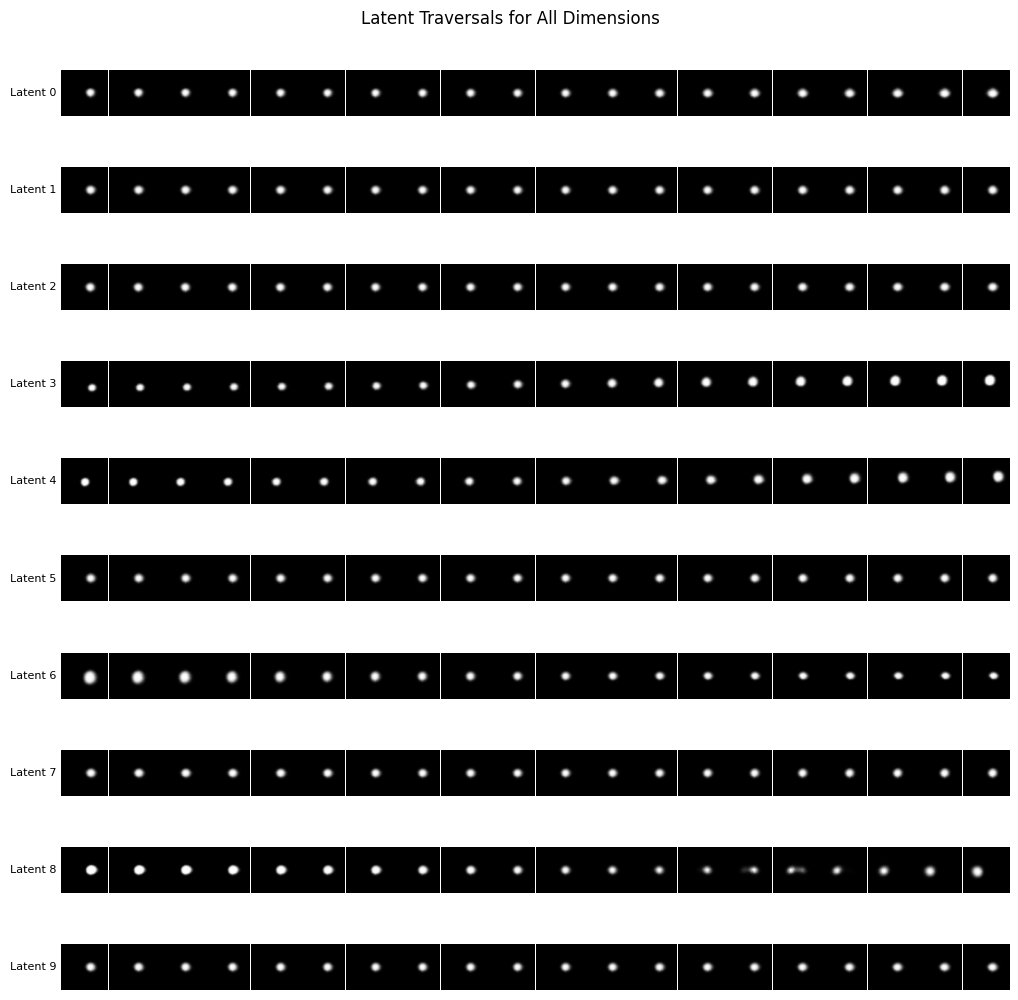

In [ ]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, num_samples=20)
plt.show()

## Metric Evaluation (dSprites)

In [ ]:
print("\n===== Computing Metrics for dSprites =====")
metric_aggregator_dsprites = MetricAggregator(metrics=metrics_to_compute)

metrics_results_dsprites = metric_aggregator_dsprites.compute(model=model_dsprites, 
                                                            data_loader=dsprites_dataloader, 
                                                            device=device)
print("dSprites Metrics:", metrics_results_dsprites)


===== Computing Metrics for dSprites =====


Computing representations: 100%|██████████| 11520/11520 [00:21<00:00, 544.08it/s]


dSprites Metrics: {'dci_d': {'disentanglement': 0.04806127219267424, 'completeness': 0.06966468014544981, 'informativeness_train_scores': 0.83532, 'informativeness_test_scores': 0.3436, 'informativeness_train_errors': 0.16468000000000002, 'informativeness_test_errors': 0.6564}, 'mig': 0.04420432315348423}
